In [1]:

import sys
sys.path
sys.path.append('/Users/agos/Dropbox/ColumbiaProjects/Code_Dans_Package/analysis_dan/')
sys.path.append('/Users/agos/Dropbox/ColumbiaProjects/Code_Dans_Package/OASIS-master')

import warnings
warnings.filterwarnings('ignore')

import calnet.calnet as cc
import calnet.dynamics as dyn
import numpy as np
from importlib import reload
import pdb
import matplotlib.pyplot as plt
import glob
import calnet.utils as utils
import pyute as ut
import size_contrast_analysis as sca
import size_contrast_figures as scf
import size_contrast_opto_figures as scof
import opto_utils
import os
import scipy.stats as sst
from tqdm import tqdm
reload(cc)
reload(utils)

<module 'calnet.utils' from '/Users/agos/Dropbox/ColumbiaProjects/Code_Dans_Package/analysis_dan/calnet/utils.py'>

In [2]:
os.getcwd()

figures_path='/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/figures_notebooks_agos'

In [3]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('Reds')


In [4]:
cache_base = os.path.expanduser('~/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/mossing_paper_code')
if not os.path.exists(cache_base):
    os.makedirs(cache_base)
cache_base = os.path.join(cache_base, "vip_sst_subnetwork_dynamics_")

In [5]:
# weights_files = glob.glob('../shared_data/calnet_data/weights/weights_201215b/*.npy')
weights_files_loaded = glob.glob('/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data/weights/weights_210513c/*.npy')
weights_files_loaded.sort()


In [6]:

def get_low_loss_models(weights_files_orig):

    def build_models(weights_files):
        #weights_files = np.load(weights_files_list_file,allow_pickle=True)
        nwt = len(weights_files)
        mdls = [None for iwt in range(nwt)]
        for iwt in range(nwt):
            wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
            mdls[iwt] = cc.ModelOri(wtdict,nT=1)

        return mdls

    def get_loss_dist(weights_files):
        nwt = len(weights_files)
        losses = np.zeros((nwt,))
        for iwt in range(nwt):
            wtdict = np.load(weights_files[iwt],allow_pickle=True)[()];
            losses[iwt] = cc.ModelOri(wtdict,nT=1).loss
        low_loss = (losses<np.nanpercentile(losses,10))
        return low_loss

    low_loss=get_loss_dist(weights_files_orig)
    weights_files = [wf for (wf,ll) in zip(weights_files_orig,low_loss) if ll]
    mdls=build_models(weights_files)

    return mdls, weights_files

mdls, weights_files =get_low_loss_models(weights_files_loaded)

print('From ' +str(len(weights_files_loaded)) +' fitted models now you have ' + str(len(weights_files)))


From 950 fitted models now you have 94


# Load sims

In [7]:
npyfile = np.load('/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data/dynamics/vip_both_pixels_opto_tavg_210513c.npy',allow_pickle=True)[()]

YY_opto_loaded = npyfile['YY_opto'][:,:,:,np.newaxis,:]
print('size of loaded YY_opto' + str(YY_opto_loaded.shape))
network_resp_loaded=np.nanmean(YY_opto_loaded,3)
print('size of temporally averaged YY_opto= network_resp' + str(network_resp_loaded.shape))



size of loaded YY_opto(94, 31, 36, 1, 8)
size of temporally averaged YY_opto= network_resp(94, 31, 36, 8)


The number of valid models you now have is 89


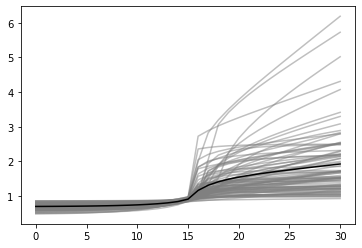

In [8]:
lkat_aux = ut.k_and(*[network_resp_loaded.max(1).max(1).max(1) < 10])
print('The number of valid models you now have is ' +str(sum(lkat_aux)))
YY_opto=YY_opto_loaded[lkat_aux,:,:,:,:]
network_resp=network_resp_loaded#[lkat_aux,:,:,:]
plt.plot(YY_opto[:,:,5,0,0].T,color='gray',alpha=0.5);
plt.plot(np.nanmean(YY_opto[:,:,5,0,0],0),'k');


In [9]:
network_resp.shape

(94, 31, 36, 8)

# Params for plots

In [10]:
opto_levels = 1*np.linspace(-1,1,YY_opto.shape[1])
ucontrast=np.array([0,6,12,25,50,100])

# Compute response

In [11]:
YY_opto.shape


(89, 31, 36, 1, 8)

# Get params

In [12]:

def two_asymptote_fn(x,*params):
    # left asymptote: y = x*a1 + b1
    # right asymptote: y = x*a2 + b2
    # around x = x0, interpolate sigmoidally
    # between the two asymptotes with length constant lam in x
    x0,a1,b1,a2,b2,lam = params
    as1 = a1*x + b1
    as2 = a2*x + b2
    factor = 1/(1+np.exp((x-x0)/lam))
    return factor*as1 + (1-factor)*as2

def fit_opt_params_two_asymptote_fn(x,R,epsilon=1e-8):
    # left asymptote: y = x*a1 + b1
    # right asymptote: y = x*a2 + b2
    # around x = x0, interpolate sigmoidally
    # between the two asymptotes with length constant lam in x
    # given R, return optimal (x0,a1,b1,a2,b2,lam)
    # R is a nsizes x len(x) array of responses
    nsizes = R.shape[0]
    x0_0 = x[np.argsort(R,axis=1)[:,R.shape[1]//2]] # index of the median of R along each row
    # x0_0 = np.mean(x)*np.ones((nsizes,))
    a1_0 = (R[:,1]-R[:,0])/(x[1]-x[0])
    b1_0 = R[:,0] - a1_0[:]*x[0]
    a2_0 = (R[:,-1]-R[:,-2])/(x[-1]-x[-2])
    b2_0 = R[:,-1] - a2_0[:]*x[-1]
    lam_0 = 0.1*(x[1]-x[0])*np.ones((nsizes,))
    bds = [(-np.inf,np.inf) for _ in range(5)] + [(epsilon,np.inf)]
    #bds = zip_pairs(bds)
    params_0 = np.concatenate([z[:,np.newaxis] for z in (x0_0,a1_0,b1_0,a2_0,b2_0,lam_0)],axis=1)

    nvar = 6
    popt = np.nan*np.ones((nsizes,nvar))
    pcov = np.nan*np.ones((nsizes,nvar,nvar))
    def f(*params):
        return two_asymptote_fn(x,*params) 
    # def fprime(x,*params):
    #     return grad(f)(x,*params)
    for isize in range(nsizes):
        def cost(params):
            return np.sum((R[isize] - f(*params))**2)
        def costprime(params):
            return grad(cost)(params)
        res = sop.minimize(cost,x0=params_0[isize,:],bounds=bds,method='L-BFGS-B',jac=costprime)
        popt[isize] = res.x
        pcov[isize] = res.jac
#        if not res.success:
#            print('did not work for %d'%isize)
        #popt[isize],pcov[isize] = sop.curve_fit(two_asymptote_fn,x,R[isize],p0=params_0[isize],bounds=bds)
        #try:
        #    popt[isize],pcov[isize] = sop.curve_fit(two_asymptote_fn,x,R[isize],p0=params_0[isize],bounds=bds)
        #except:
        #    print('did not work for %d'%isize)
        #    popt[isize] = params_0[isize]
    return popt,pcov


In [13]:
# nr = network_resp
nr = np.nanmean(YY_opto,3)# time average

import naka_rushton_analysis as nra
reload(nra)
x = opto_levels#-opto_levels.min()#+1
params = np.zeros((nr.shape[0],nr.shape[2],3,6))
use_zero_dims = True
for istim in tqdm(range(nr.shape[2])):
    for itype in range(3):
        if use_zero_dims:
            if itype in {0, 1}:
                zero_dims = [False, True, False, True, False, False]
            else:
                assert itype == 2
                zero_dims = [False, True, False, False, False, False]
        else:
            zero_dims = None
        params[:,istim,itype,:],_ = nra.fit_opt_params_two_asymptote_fn(x, nr[:,:,istim,itype])#, zero_dims=zero_dims)
        # params[:,istim,itype,:],_ = nra.fit_opt_params_two_asymptote_fn_joint(x, nr[:,:,istim,itype], zero_dims=zero_dims)

 31%|███       | 11/36 [00:39<01:30,  3.63s/it]


KeyboardInterrupt: 

In [ ]:
x0,a1,b1,a2,b2,lam=params[0,0,1,:]

# Compute the supression index

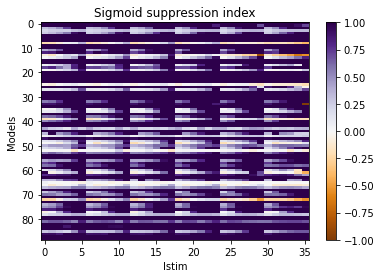

In [ ]:
sigmoid_supression_index=np.zeros_like(params[:,:,:,0])
for n_models in range(params.shape[0]):
    for istim in range(params.shape[1]):
        for cell_type in range(params.shape[2]):
            taf=two_asymptote_fn(x,*params[n_models,istim,cell_type,:])

            sigmoid_supression_index[n_models,istim,cell_type]=(np.abs(taf[20]-taf[15])/np.abs(taf[25]-taf[20]))-1
            
            
# Create a figure and axis
fig, ax = plt.subplots()


# Plot 

im=ax.imshow(sigmoid_supression_index[:,:,0],aspect='auto',vmin=-1,vmax=1,cmap='PuOr')
fig.colorbar(im)

# Add labels and title
ax.set_xlabel('Istim')
ax.set_ylabel('Models')
ax.set_title('Sigmoid suppression index')
# ax.set_xlim([-0.5,0.8])

# Save the figure as a PDF
plt.savefig('sigmoid_supression_index_map.pdf', format='pdf')

# Show the plot (optional)
plt.show()

[0.33333333]
[0.25]
[0.2734375]


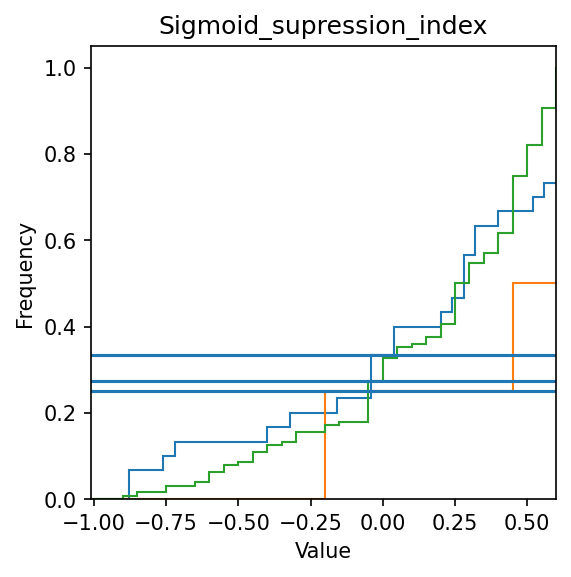

In [ ]:



# Create a figure and axis
fig, ax = plt.subplots(figsize=(4,4),dpi=150)


# Plot the staircase-like histogram
hist, edges, dummy = plt.hist(sigmoid_supression_index[:,34:,1].flatten(), bins=np.arange(-1, 1, 0.04),density=True,cumulative=True,histtype='step')
zero_val,=np.where(np.abs(edges)<0.0001)
ax.axhline(hist[zero_val-1])
print(hist[zero_val-1])
hist, edges, dummy = plt.hist(sigmoid_supression_index[:,2:3,1].flatten(), bins=np.arange(-1.1, 1, 0.05),density=True,cumulative=True,histtype='step')
zero_val,=np.where(np.abs(edges)<0.0001)
print(hist[zero_val-1])
ax.axhline(hist[zero_val-1])
hist, edges, dummy = plt.hist(sigmoid_supression_index[:,:,1].flatten(), bins=np.arange(-1.1, 0.7, 0.05),density=True,cumulative=True,histtype='step')
zero_val,=np.where(np.abs(edges)<0.0001)
ax.axhline(hist[zero_val-1])
print(hist[zero_val-1])



# Add labels and title
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Sigmoid_supression_index')
ax.set_xlim([-1.01,0.6])

# Save the figure as a PDF
plt.savefig('staircase_histogram_sigmoid_supression_index_SST.pdf', format='pdf')

# Show the plot (optional)
plt.show()

In [ ]:
taf=two_asymptote_fn(x,*params[n_models,istim,0,:])


1.9856258975447867

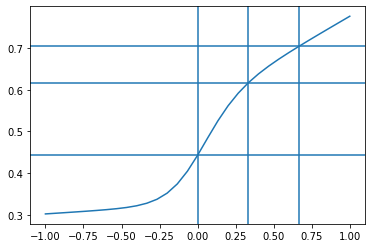

In [ ]:
tf=two_asymptote_fn(x,*params[1,0,0,:])
plt.plot(x,tf)
# plt.axvline(x0)
plt.axvline(x[20])
plt.axvline(x[25])
plt.axvline(x[15])
plt.axhline(tf[20])
plt.axhline(tf[25])
plt.axhline(tf[15])

((tf[25]-tf[20])-(tf[15]-tf[20]))/(tf[25]-tf[20])-1

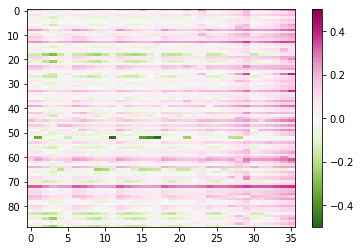

In [ ]:
plt.imshow(params[:,:,0,0],cmap='PiYG_r',vmin=-0.5,vmax=0.5,aspect='auto');
plt.colorbar()

[0.]
[0.]
[0.00031211]


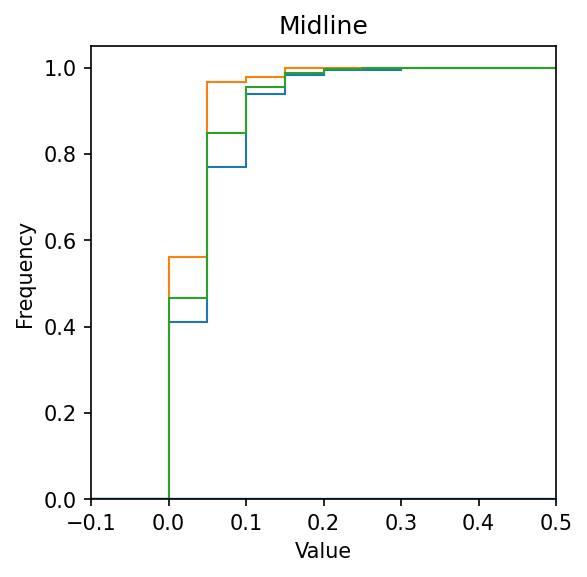

In [ ]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4,4),dpi=150)


# Plot the staircase-like histogram
hist, edges, dummy = plt.hist(params[:,34:,0,1].flatten(), bins=np.arange(-0.3,0.7, 0.05),density=True,cumulative=True,histtype='step')
zero_val,=np.where(np.abs(edges)<0.0001)
ax.axhline(hist[zero_val-1])
print(hist[zero_val-1])
hist, edges, dummy = plt.hist(params[:,2:3,0,1].flatten(), bins=np.arange(-0.3,0.7, 0.05),density=True,cumulative=True,histtype='step')
zero_val,=np.where(np.abs(edges)<0.0001)
ax.axhline(hist[zero_val-1])
print(hist[zero_val-1])

hist, edges, dummy = plt.hist(params[:,:,0,1].flatten(), bins=np.arange(-0.3,0.7, 0.05),density=True,cumulative=True,histtype='step')
zero_val,=np.where(np.abs(edges)<0.0001)
ax.axhline(hist[zero_val-1])
print(hist[zero_val-1])

# Add labels and title
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Midline')
ax.set_xlim([-0.1,0.5])

# Save the figure as a PDF
plt.savefig('staircase_histogram_midline_SST.pdf', format='pdf')

# Show the plot (optional)
plt.show()

In [ ]:
params.shape

(83, 36, 3, 6)

In [ ]:
midpoints = params[:, :, itype, 0].reshape((-1, 6, 6))
# np.save(os.path.expanduser('~/Documents/notebooks/mossing-PC/shared_data/vip_sigmoid_midpoints.npy'), midpoints)

scales = params[:, :, itype, 5].reshape((-1, 6, 6))
# np.save(os.path.expanduser('~/Documents/notebooks/mossing-PC/shared_data/vip_sigmoid_scales.npy'), scales)


# Plot only Pyr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


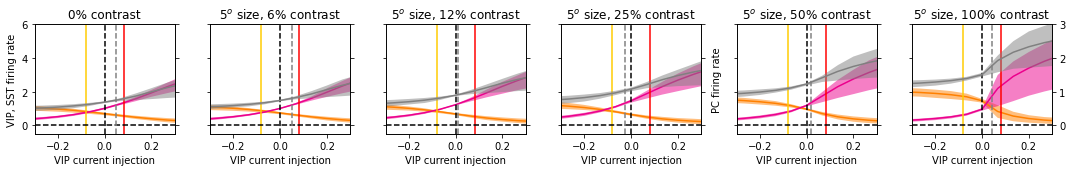

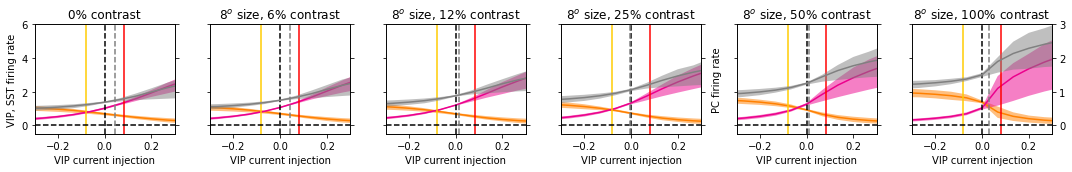

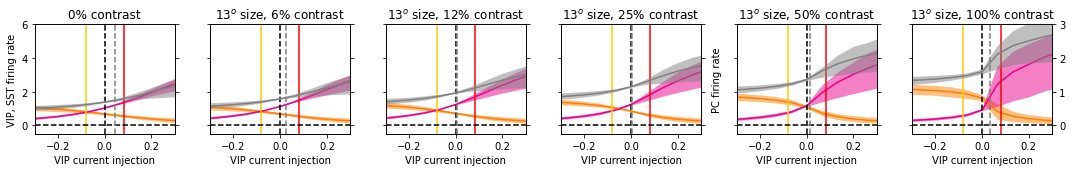

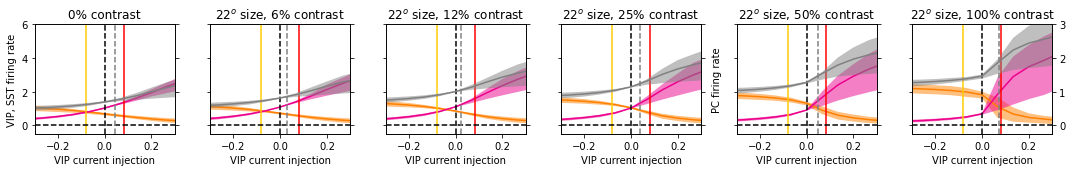

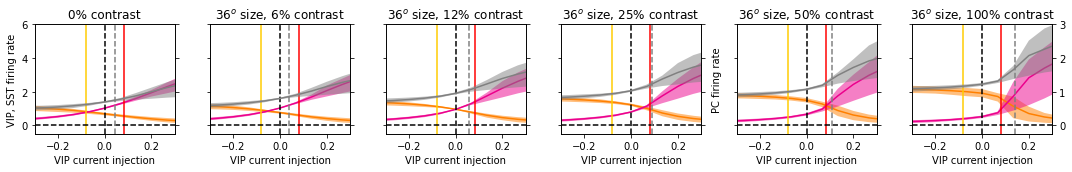

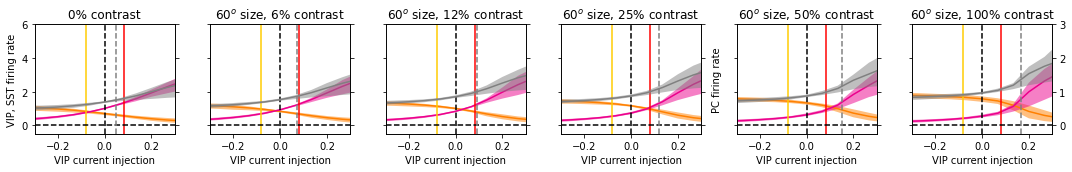

In [ ]:
%load_ext autoreload
%autoreload 2

alpha = 0.5

izero = 15
zero_subtracted = False

norm_to_mean = True

lkat = ut.k_and(*[network_resp.max(1).max(1).max(1) < 10 for iconn in [0,2,3,4]])

reload(ut)

def plot_nonlinearity(ax, network_resp,color,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = network_resp - network_resp[:,izero:izero+1]
    else:
        to_plot = network_resp - 0
    ax.plot(opto_levels,np.nanmean(to_plot,0),c=color,label=label)
    ax.fill_between(opto_levels,np.nanpercentile(to_plot,pct_l,axis=0),np.nanpercentile(to_plot,pct_u,axis=0),facecolor=color,alpha=alpha)

def plot_cell_intrinsic_resp(cell_intrinsic_resp,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = cell_intrinsic_resp - cell_intrinsic_resp[:,izero:izero+1]
    else:
        to_plot = cell_intrinsic_resp - 0
    plt.plot(opto_levels,np.nanmean(to_plot,0),c='k',linestyle='dashed',label=label)
    
    
usize = np.array((5,8,13,22,36,60))
# itype = 2
pct_l,pct_u = 16,80
# istims = [0,5,35,18,20,23]
all_titles = [f"{size}$^o$ size, {contrast}% contrast" for size in usize for contrast in ucontrast]
all_titles[0::6] = ["0% contrast" for _ in range(6)]
# titles = ['0% contrast','5$^o$ size, 100% contrast','60$^o$ size, 100% contrast','0% contrast','22$^o$ size, 12% contrast','22$^o$ size, 100% contrast']
cs = [None,np.array((1,0.65,0)),np.array((1,0,1)),None]

this_target_amplitude = np.nanmean(params[:,5::6,0,0],axis=1)
line_loc = this_target_amplitude.mean()

xlim = 0.3 # 0.5

midline=np.mean(params[:,:,0,0],0)

istims_list = [np.arange(k,k+6,1) for k in range(0,36,6)]

for istim_choice in range(len(istims_list)):
    istims = istims_list[istim_choice]
    titles = [all_titles[istim] for istim in istims]
    for istyle in range(1):
        fig, axs = plt.subplots(1,len(istims),figsize=(2.5*len(istims),2.5), sharey=True)
        this_lkat = slice(None)
        for iistim,(istim,title) in enumerate(zip(istims,titles)):

            nrs = [network_resp]
            nr_baseline = network_resp
            cs = [np.array((0.5,0.5,0.5)),np.array((1,0.5,0)),np.array((236, 0, 140))/255,np.array((0,0,1))]
            lbls = ['baseline','PC$\rightarrow$SST weights deleted','PC$\rightarrow$VIP weights deleted','PC$\leftrightarrow$PV weights deleted']
            for iplot,(nr,c,lbl) in enumerate(zip(nrs[:1],cs[:1],lbls[:1])):

                if norm_to_mean:
                    nr = ut.norm_middle_axes_to_mean(nr[:,:,:,:],nr_baseline[:,15,:,:])
                pc_ax = axs[iistim].twinx()
                for itype in range(3):
                    if itype==0:
                        this_ax = pc_ax
                    else:
                        this_ax = axs[iistim]
                    plot_nonlinearity(this_ax, nr[lkat][this_lkat][:,:,istim,itype],cs[itype],lbl)
                axs[iistim].axvline(line_loc,c=np.array((1,0,0)))
                axs[iistim].axvline(-line_loc,c=np.array((1,0.8,0)))
                axs[iistim].axvline(0,c='k',linestyle='dashed')
                axs[iistim].axhline(0,c='k',linestyle='dashed')
                axs[iistim].axvline(midline[istim],c='gray',linestyle='dashed')
                
                if istyle == 2:
                    axs[iistim].set_xlim((-0.5, 0.5))
                else:
                    axs[iistim].set_xlim((-xlim, xlim))

                if norm_to_mean:
                    axs[iistim].set_ylim((-0.5,6))
                    pc_ax.set_ylim((-0.25, 3.0))
                else:
                    axs[iistim].set_ylim((-1,3))
                    pc_ax.set_ylim((-1, 3))

                if iistim < len(istims)-1:
                    pc_ax.set_yticklabels([])


                axs[iistim].set_xlabel('VIP current injection')
                if zero_subtracted:
                    axs[iistim].set_ylabel(r'$\Delta$firing rate')
                else:
                    if iistim == 0:
                        axs[iistim].set_ylabel('VIP, SST firing rate')
                    if iistim == 3:
                        pc_ax.set_ylabel('PC firing rate')
            fig.tight_layout()
            axs[iistim].set_title(title)
            fig.tight_layout()
            save = False

        plt.savefig(figures_path+'/network_nonlinearity_all_connections_size_contrast_samples.pdf',dpi=300)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


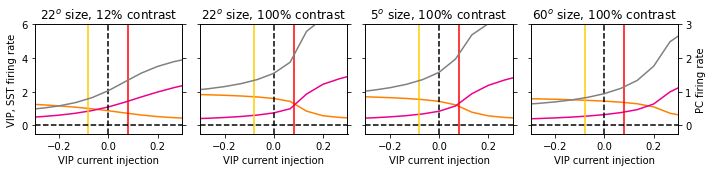

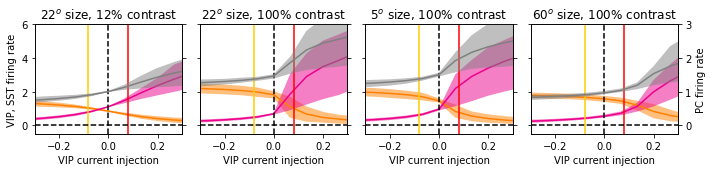

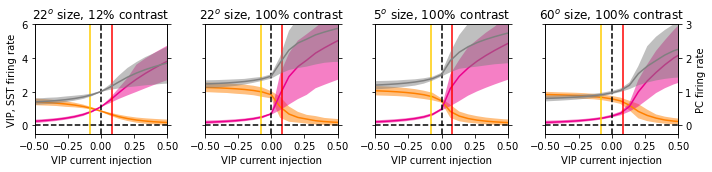

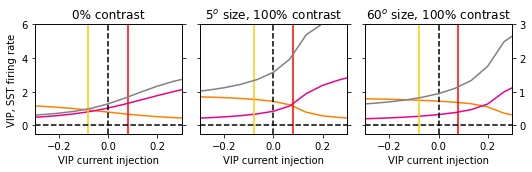

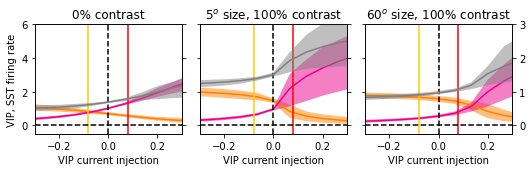

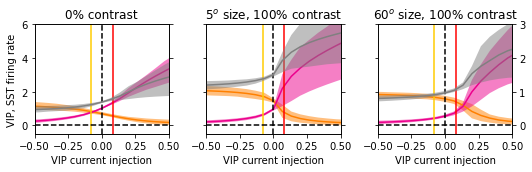

In [ ]:
%load_ext autoreload
%autoreload 2

alpha = 0.5

izero = 15
zero_subtracted = False

norm_to_mean = True

lkat = ut.k_and(*[network_resp.max(1).max(1).max(1) < 10 ])

reload(ut)

def plot_nonlinearity(ax, network_resp,color,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = network_resp - network_resp[:,izero:izero+1]
    else:
        to_plot = network_resp - 0
    ax.plot(opto_levels,np.nanmean(to_plot,0),c=color,label=label)
    ax.fill_between(opto_levels,np.nanpercentile(to_plot,pct_l,axis=0),np.nanpercentile(to_plot,pct_u,axis=0),facecolor=color,alpha=alpha)

def plot_cell_intrinsic_resp(cell_intrinsic_resp,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = cell_intrinsic_resp - cell_intrinsic_resp[:,izero:izero+1]
    else:
        to_plot = cell_intrinsic_resp - 0
    plt.plot(opto_levels,np.nanmean(to_plot,0),c='k',linestyle='dashed',label=label)
    
    
usize = np.array((5,8,13,22,36,60))
# itype = 2
pct_l,pct_u = 16,84
# istims = [0,5,35,18,20,23]
all_titles = [f"{size}$^o$ size, {contrast}% contrast" for size in usize for contrast in ucontrast]
all_titles[0::6] = ["0% contrast" for _ in range(6)]
# titles = ['0% contrast','5$^o$ size, 100% contrast','60$^o$ size, 100% contrast','0% contrast','22$^o$ size, 12% contrast','22$^o$ size, 100% contrast']
cs = [None,np.array((1,0.65,0)),np.array((1,0,1)),None]

this_target_amplitude = np.nanmean(params[:,5::6,0,0],axis=1)
line_loc = this_target_amplitude.mean()

xlim = 0.3 # 0.5

istims_list = [
    [20, 23, 5, 35],
    [0, 5, 35]
]

for istim_choice in range(2):
    istims = istims_list[istim_choice]
    titles = [all_titles[istim] for istim in istims]
    for istyle in range(3):
        # plt.figure(figsize=(2.5*len(istims),2.5))
        fig, axs = plt.subplots(1,len(istims),figsize=(2.5*len(istims),2.5), sharey=True)
        if istyle==0:
            np.random.seed(0)
            this_lkat = np.random.randint(lkat.sum())
            this_lkat = slice(this_lkat, this_lkat+1)
        else:
            this_lkat = slice(None)
        for iistim,(istim,title) in enumerate(zip(istims,titles)):
        #     plot_cell_intrinsic_resp(cell_intrinsic_resp[:,:,istim,itype],'cell-intrinsic nonlinearity')
        #     plt.plot(opto_levels,np.nanmean(cell_intrinsic_resp,0)[:,istim,itype],c='k',linestyle='dashed',label='cell-intrinsic nonlinearity')
        #     plt.fill_between(opto_levels,np.nanpercentile(cell_intrinsic_resp,pct_l,axis=0)[:,istim,itype],np.nanpercentile(cell_intrinsic_resp,pct_u,axis=0)[:,istim,itype],facecolor='k',alpha=0.5)

            nrs = [network_resp]
            nr_baseline = network_resp
        #     cs = ['k',np.array((1,0.65,0)),np.array((1,0,1)),np.array((0,0,1))]
            cs = [np.array((0.5,0.5,0.5)),np.array((1,0.5,0)),np.array((236, 0, 140))/255,np.array((0,0,1))]
            lbls = ['baseline','PC$\rightarrow$SST weights deleted','PC$\rightarrow$VIP weights deleted','PC$\leftrightarrow$PV weights deleted']
            for iplot,(nr,c,lbl) in enumerate(zip(nrs[:1],cs[:1],lbls[:1])):
                if norm_to_mean:
                    nr = ut.norm_middle_axes_to_mean(nr[:,:,:,:],nr_baseline[:,15,:,:])
                pc_ax = axs[iistim].twinx()
                for itype in range(3):
        #             plot_nonlinearity(nr[lkat][:,:,istim,itype],cs[itype],lbl)
                    if itype==0:
                        this_ax = pc_ax
                    else:
                        this_ax = axs[iistim]
                    plot_nonlinearity(this_ax, nr[lkat][this_lkat][:,:,istim,itype],cs[itype],lbl)
                axs[iistim].axvline(line_loc,c=np.array((1,0,0)))
                axs[iistim].axvline(-line_loc,c=np.array((1,0.8,0)))
                axs[iistim].axvline(0,c='k',linestyle='dashed')
                axs[iistim].axhline(0,c='k',linestyle='dashed')
        #         plt.xlim((-1.5,1.5))
                if istyle == 2:
                    axs[iistim].set_xlim((-0.5, 0.5))
                else:
                    axs[iistim].set_xlim((-xlim, xlim))
        #         plt.xlim((-0.25,0.25))
        #         plt.ylim((-1,3.5))
                if norm_to_mean:
                    axs[iistim].set_ylim((-0.5,6))
                    pc_ax.set_ylim((-0.25, 3.0))
                else:
                    axs[iistim].set_ylim((-1,3))
                    pc_ax.set_ylim((-1, 3))
        #         plt.ylim((-0.75,2.5))
#                 ut.erase_top(axs[iistim])
#                 ut.erase_top(pc_ax)
                if iistim < len(istims)-1:
                    pc_ax.set_yticklabels([])

        #     plt.plot(opto_levels,np.nanmean(network_resp,0)[:,istim,itype],c='k',label='baseline')
        #     plt.fill_between(opto_levels,np.nanpercentile(network_resp,pct_l,axis=0)[:,istim,itype],np.nanpercentile(network_resp,pct_u,axis=0)[:,istim,itype],facecolor='k',alpha=0.5)

        #     plt.plot(opto_levels,np.nanmean(network_resp_no_pcvip,0)[:,istim,itype],c=cs[2],label='PC$\rightarrow$VIP weights deleted')
        #     plt.fill_between(opto_levels,np.nanpercentile(network_resp_no_pcvip,pct_l,axis=0)[:,istim,itype],np.nanpercentile(network_resp_no_pcvip,pct_u,axis=0)[:,istim,itype],facecolor=cs[2],label='PC$\leftrightarrow$PC weights deleted',alpha=0.5)

        #     plt.plot(opto_levels,np.nanmean(network_resp_no_pcsst,0)[:,istim,itype],c=cs[1],label='PC$\rightarrow$SST weights deleted')
        #     plt.fill_between(opto_levels,np.nanpercentile(network_resp_no_pcsst,pct_l,axis=0)[:,istim,itype],np.nanpercentile(network_resp_no_pcsst,pct_u,axis=0)[:,istim,itype],facecolor=cs[1],label='PC$\leftrightarrow$PV weights deleted',alpha=0.5)

            # plt.legend()
        #         plt.xlim((-1.5,1.5))

                axs[iistim].set_xlabel('VIP current injection')
                if zero_subtracted:
                    axs[iistim].set_ylabel(r'$\Delta$firing rate')
                else:
                    if iistim == 0:
                        axs[iistim].set_ylabel('VIP, SST firing rate')
                    if iistim == 3:
                        pc_ax.set_ylabel('PC firing rate')
            # plt.title('PC$\leftrightarrow$PC weights deleted')
            fig.tight_layout()
        #     plt.savefig('figures/network_nonlinearity_w_and_wo_ws_stim_%d_no_title.jpg'%istim,dpi=300)
        #     plt.savefig('figures/sst_network_nonlinearity_w_and_wo_ws_stim_%d_no_title.jpg'%istim,dpi=300)
            axs[iistim].set_title(title)
            fig.tight_layout()
            save = False
            if save:
                if istim_choice == 0:
                    suffix = ""
                else:
                    suffix = "_just_size"
                if istyle == 0:
                    plt.savefig(f'figures/network_nonlinearity_all_connections_size_contrast_samples_example_twinx{suffix}.jpg',dpi=300)
                if istyle == 1:
                    plt.savefig(f'figures/network_nonlinearity_all_connections_size_contrast_samples_twinx{suffix}.jpg',dpi=300)
                if istyle == 2:
                    plt.savefig(f'figures/network_nonlinearity_all_connections_size_contrast_samples_twinx_wider{suffix}.jpg',dpi=300)

In [ ]:
istims_list

[array([0, 1, 2, 3, 4, 5]),
 array([ 6,  7,  8,  9, 10, 11]),
 array([12, 13, 14, 15, 16, 17]),
 array([18, 19, 20, 21, 22, 23]),
 array([24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35])]

In [ ]:
ucontrast

array([  0,   6,  12,  25,  50, 100])

In [ ]:
nr[lkat][this_lkat][:,:,istim,itype].shape

(83, 41)

In [ ]:
itype = 0


def compute_amplitude_at_x0(set_of_params):
    x0, a1, b1, a2, b2, lam = set_of_params
    return a2*x0 + b2 - (a1*x0 + b1)

def apply_func_to_pc_params(params, func):
    itype = 0
    output = np.zeros(params.shape[:2])
    for iwt in range(params.shape[0]):
        for istim in range(params.shape[1]):
            output[iwt,istim] = func(params[iwt,istim,itype,:])
    return output

amplitude_at_x0 = apply_func_to_pc_params(params, compute_amplitude_at_x0)
# np.save(os.path.expanduser("~/Documents/notebooks/mossing-PC/shared_data/vip_sigmoid_amplitude_at_x0.npy"), amplitude_at_x0)

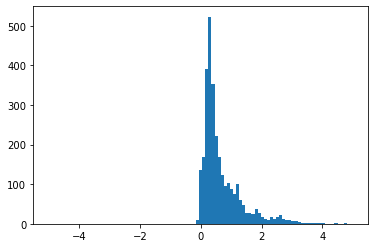

In [ ]:
amplitude_at_x0
plt.hist(amplitude_at_x0.flatten(),bins=np.linspace(-5,5,100));

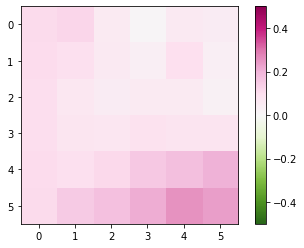

In [ ]:
midpoints # model nr, size, contrast
plt.imshow(midpoints[3,:,:],cmap='PiYG_r',vmin=-0.5,vmax=0.5);
plt.colorbar()

In [ ]:
midpoints.shape

(83, 6, 6)

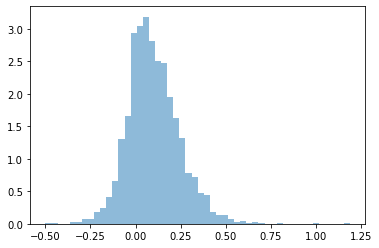

In [ ]:
plt.hist(params[:,:,0,0].flatten(),50,density=True,alpha=0.5);
# plt.hist(np.nanmean(params[:,:,0,0],0).flatten(),7,density=True,alpha=0.5);


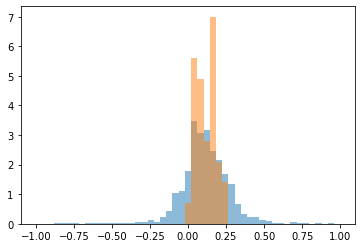

In [ ]:
plt.hist(params[:,:,1,0].flatten(),np.linspace(-1,1,50),density=True,alpha=0.5);
plt.hist(np.nanmean(params[:,:,1,0],0).flatten(),np.linspace(-1,1,50),density=True,alpha=0.5);


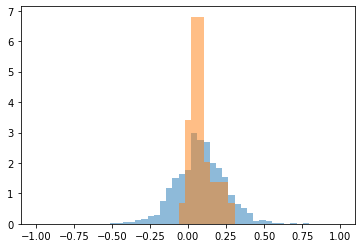

In [ ]:
plt.hist(params[:,:,2,0].flatten(),np.linspace(-1,1,50),density=True,alpha=0.5);
plt.hist(np.nanmean(params[:,:,2,0],0).flatten(),np.linspace(-1,1,50),density=True,alpha=0.5);
